In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\Jesse\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [2]:
data_path = 'C:/Users/Jesse/Desktop/midterm_data/data/'

In [10]:
flights = pd.read_csv(data_path + 'flights.csv', parse_dates=['fl_date'])

In [4]:
passengers = pd.read_csv(data_path + 'passengers.csv')

In [5]:
fuel = pd.read_csv(data_path+'fuel_comsumption.csv')

In [17]:
# Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
flights['month'] = flights['fl_date'].dt.month

In [33]:
carrier_avg_delay_month = pd.DataFrame(flights.loc[(flights['dep_delay'].notna())].groupby(['month','mkt_unique_carrier'])['dep_delay'].mean().reset_index())

In [35]:
# Distance in miles
carrier_avg_distance_month = pd.DataFrame(flights.groupby(['month', 'mkt_unique_carrier'])['distance'].sum().reset_index())

In [50]:
# More because there are internation carriers

# Is the domestic US carriers contained within the international passengers['unique_carrier'] carriers?
set(carrier_avg_distance_month['mkt_unique_carrier'].unique()).issubset(set(passengers['unique_carrier'].unique())) # True

True

In [53]:
passengers_carrier = pd.DataFrame(passengers.loc[
    passengers['unique_carrier'].isin(carrier_avg_distance_month['mkt_unique_carrier'].unique())
].groupby('unique_carrier')['passengers'].sum().reset_index())

In [67]:
carrier_fuel_consumption = pd.DataFrame(fuel.loc[
    fuel['unique_carrier'].isin(passengers_carrier['unique_carrier'].values)
].groupby('unique_carrier')['tdomt_gallons'].sum().reset_index())

In [69]:
# carrier_avg_delay_month, carrier_avg_distance_month, passengers_carrier, carrier_fuel_consumption

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [82]:
x = pd.DataFrame(
    carrier_avg_delay_month.groupby(
        'mkt_unique_carrier')['dep_delay'].sum().reset_index()).rename({'dep_delay': 'dep_delay_summed_monthly_mean', 'mkt_unique_carrier': 'unique_carrier'}, axis=1)
x


,unique_carrier,dep_delay_summed_monthly_mean
0,AA,122.922559
1,AS,43.970531
2,B6,200.772973
3,DL,112.087968
4,F9,201.982368
5,G4,133.048804
6,HA,18.974288
7,NK,123.374642
8,UA,153.818058
9,VX,18.235335


In [83]:
y = pd.DataFrame(
    carrier_avg_distance_month.groupby('mkt_unique_carrier')['distance'].sum().reset_index()).rename({'distance': 'distance_summed_monthly_mean', 'mkt_unique_carrier': 'unique_carrier'}, axis=1)

y

,unique_carrier,distance_summed_monthly_mean
0,AA,2875349237
1,AS,838413866
2,B6,656120291
3,DL,2435523712
4,F9,263828340
5,G4,176313111
6,HA,120940267
7,NK,383895843
8,UA,2432847105
9,VX,25864306


In [80]:
passengers_carrier

,unique_carrier,passengers
0,AA,715203891
1,AS,145210038
2,B6,198872059
3,DL,742511388
4,F9,87767317
5,G4,62125688
6,HA,55780580
7,NK,127529568
8,UA,533886775
9,VX,25617180


In [81]:
carrier_fuel_consumption

,unique_carrier,tdomt_gallons
0,AA,1.005715e+10
1,AS,2.628731e+09
2,B6,3.034503e+09
3,DL,9.506876e+09
4,F9,1.034765e+09
5,G4,8.468571e+08
6,HA,8.342171e+08
7,NK,1.510093e+09
8,UA,7.618816e+09
9,VX,5.630055e+08


In [86]:
from functools import reduce

final = reduce(lambda x,y: pd.merge(x,y, on='unique_carrier', how='outer'), [carrier_fuel_consumption, passengers_carrier, x, y])

In [87]:
final.to_csv('./final_task10.csv')

In [88]:
final

,unique_carrier,tdomt_gallons,passengers,dep_delay_summed_monthly_mean,distance_summed_monthly_mean
0,AA,1.005715e+10,715203891,122.922559,2875349237
1,AS,2.628731e+09,145210038,43.970531,838413866
2,B6,3.034503e+09,198872059,200.772973,656120291
3,DL,9.506876e+09,742511388,112.087968,2435523712
4,F9,1.034765e+09,87767317,201.982368,263828340
5,G4,8.468571e+08,62125688,133.048804,176313111
6,HA,8.342171e+08,55780580,18.974288,120940267
7,NK,1.510093e+09,127529568,123.374642,383895843
8,UA,7.618816e+09,533886775,153.818058,2432847105
9,VX,5.630055e+08,25617180,18.235335,25864306


Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [89]:
final['fuel_comp_per_passenger_per_mile'] = final.apply(lambda row: (row['tdomt_gallons']/row['passengers'])/row['distance_summed_monthly_mean'], axis=1)

In [91]:
final.sort_values('fuel_comp_per_passenger_per_mile', ascending=False)

,unique_carrier,tdomt_gallons,passengers,dep_delay_summed_monthly_mean,distance_summed_monthly_mean,fuel_comp_per_passenger_per_mile
9,VX,5.630055e+08,25617180,18.235335,25864306,8.497291e-07
6,HA,8.342171e+08,55780580,18.974288,120940267,1.236588e-07
5,G4,8.468571e+08,62125688,133.048804,176313111,7.731332e-08
4,F9,1.034765e+09,87767317,201.982368,263828340,4.468762e-08
7,NK,1.510093e+09,127529568,123.374642,383895843,3.084462e-08
2,B6,3.034503e+09,198872059,200.772973,656120291,2.325575e-08
1,AS,2.628731e+09,145210038,43.970531,838413866,2.159191e-08
8,UA,7.618816e+09,533886775,153.818058,2432847105,5.865749e-09
10,WN,9.504557e+09,803499970,127.603398,2022776676,5.847875e-09
3,DL,9.506876e+09,742511388,112.087968,2435523712,5.257053e-09


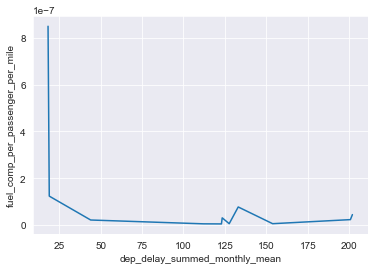

In [98]:
sns.lineplot(x='dep_delay_summed_monthly_mean', y='fuel_comp_per_passenger_per_mile', data=final)